# Example to try and learn a likelihood ratio with a neural-network

In this example, we start with a pretty simple setup where the model $f(x)$ is the sum of two Gaussian functions (equally weighted) with a parameter $\delta\mu$ that separates their means. We have just one observable, the random variable $x$. 

$$
f(x;\delta_{\mu}) = \frac{1}{2}\phi(x;-\delta_{\mu},1) + \frac{1}{2}\phi(x;\delta_{\mu},1)
$$

where $\phi(x;\mu,\sigma)$ is a Gaussian. We can try to infer the paramter $\delta\mu$ by training a neural-network classifier. First, we think about the simple case of training $H_{0}:=f(x;0)$ vs $H_{1}:=f(x;\delta_{\mu})$ for some fixed $\delta_{\mu}$.

In [1]:
#%pip install tqdm

In [2]:
%matplotlib inline

In [3]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
from tqdm import tqdm
import ipywidgets

In [4]:
import numpy,random
from scipy.stats import norm

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

# null hypothesis is a single source - Gaussian 
mu_H0 = 0
sigma_H0 = 1

xr = numpy.linspace(-5,5,100) # range for plotting model

In [5]:
def mu_1_H1_p(dmu):
  return mu_H0+dmu
def mu_2_H1_p(dmu):
  return mu_H0-dmu

In [6]:
def plot_model(dm):
    plt.plot(xr,0.5*(norm.pdf(xr,mu_1_H1_p(dm),sigma_H0)+norm.pdf(xr,mu_2_H1_p(dm),sigma_H0)),label="$H_{1}: \delta\mu=%g$"%dm)
    plt.plot(xr,norm.pdf(xr,mu_H0,sigma_H0),label="$H_{0}: \delta\mu=0$",color='black')
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    plt.ylim(0,0.6)
    plt.legend()

ipywidgets.interact(plot_model,dm=(-3,3,0.2))

interactive(children=(FloatSlider(value=0.0, description='dm', max=3.0, min=-3.0, step=0.2), Output()), _dom_c…

<function __main__.plot_model(dm)>

## Neural net classifier and likelihood ratio
If we train a classifier with the "Binary cross-entropy" loss 
$$
    BCE = -\frac{1}{N}\sum_{i=1}^{N}y_{i}\ln p_{i} + (1-y_{i})\ln(1-p_{i})
$$

and we identify our data such that $H_{0}\rightarrow y=0$ and  $H_{1}\rightarrow y=1$,
then it turns out that (provided we use the "sigmoid" layer at the end layer to format the output) the output of the neural network $\hat{g}$ will learn to approximate $g$,

$$
\hat{g}(x)\approx g(x) = \frac{f(x|H_{1})}{f(x|H_{0})+f(x|H_{1})}
$$

or re-arranging, 

$$
\frac{\hat{g}(x)}{1-\hat{g}(x)} = \frac{f(x|H_{1})}{f(x|H_{0})}
$$
but this is exactly the likelihood ratio!

## Learning a parameter

Taking the above and replacing $H_{1}$ with a family of alternative functions $H(\delta\mu)$, we can choose any value of $\delta\mu$ as a choice for $H_{0}$ - in this, we will choose $\delta\mu=0$ to identify $H_{0}$. 

Now we must use a *parametric* neural net where we provide $\delta\mu$ as an additional input to the network! Provided there is no separation power between $H_{1}$ and $H_{0}$ for $\delta\mu$ in our training data, we can use the parametric neural net approach. To acheive this, we augment the training data so that each "signal" event (i.e those identified with $H_{1}$) receives the value of $\delta\mu$ it is generated with and each "background" event (those identified with $H_{0}$) receives a random value of $\delta\mu$ drawn from the possible values! Now we will get, 

$$
 \frac{\hat{g}(x,\delta\mu)}{1-\hat{g}(x,\delta\mu)} = \frac{f(x;\delta\mu)}{f(x;0)}
$$

now for any dataset $\left\{x_{i}\right\}_{i=1}^{n}$, we can write our usual likelihood to obtain our test-statistic 

$$
q(\delta\mu) = -2\sum_{i}^{n}\ln\left(\frac{\hat{g}(x_{i},\delta\mu)}{1-\hat{g}(x_{i},\delta\mu)}\right)
$$
and finally, the usual *profiled likelihood* test statistic is just $q(\delta\mu)-q(\hat{\delta\mu})$. The nice thing is that since the neural network is differentiable, so too is $q$ and so out usual gradient descent algorithms will work very well!

In [7]:
# next the idea is to parameterize the thing and see if we can't learn the profile ratio
# dmvals = [0,0.2,0.5,0.8,1,1.2,1.5,1.8,2,2.2,2.5,3] # could use specific values or just random ones from a range
dmrange = [-3,3]

In [8]:
import random

def gen_param(n):
    #return numpy.random.uniform(dmrange[0],dmrange[1],size=n)
    return numpy.random.normal(0,1.0,size=n)

def mc_1G_2(n_events,list_of_vals):
    x=norm.rvs(mu_H0,sigma_H0,size=n_events)
    xnew = []
    for i,xx in enumerate(x) : 
        xnew.append([xx,list_of_vals[i]])
    #[ for xx in x]
    return numpy.array(xnew)

def mc_2G_2(n_events,dmu):
    mu_1_H1 = mu_H0+dmu
    mu_2_H1 = mu_H0-dmu
    
    xs = []
    for i in range(n_events):
        r = numpy.random.uniform(0,1)
        if  r > 0.5: xs.append([norm.rvs(mu_2_H1,sigma_H0,size=int(1))[0],dmu])
        else: xs.append([norm.rvs(mu_1_H1,sigma_H0,size=int(1))[0],dmu])
    
    return numpy.array(xs)

In [9]:
# step 1 is to pick random values of delta_mu, our training samples will be those ones 
# I assume I have 50,000 signal events and 50,000 background events
n_events=50000

In [10]:
def gen_data(n_events):
    
    # choose random values 
    random_dm = gen_param(n_events)
    
    # make some data, should be from H0 and H1 
    xH0 = mc_1G_2(n_events,random_dm)
    xH1 = mc_2G_2(1,random_dm[0])
    for i,n in enumerate(range(n_events-1)):
        dmu_r = random_dm[i+1] #numpy.random.uniform(dmrange[0],dmrange[1])
        xH1 = numpy.concatenate((xH1,mc_2G_2(1,dmu_r)))

    fH0 = [0 for xx in xH0]
    fH1 = [1 for xx in xH1]

    #xH0 = torch.reshape(torch.from_numpy(numpy.array(xH0)).type(torch.double),(len(dmvals)*n_events,2))
    #xH1 = torch.reshape(torch.from_numpy(numpy.array(xH1)).type(torch.double),(len(dmvals)*n_events,2))

    x = torch.from_numpy(numpy.concatenate([xH0,xH1]))
    f = torch.from_numpy(numpy.concatenate([fH0,fH1]))

    x = torch.reshape(x,(n_events*2,2)).type(torch.double)
    f = torch.reshape(f,(n_events*2,1)).type(torch.double)
    return x,f

x,f   = gen_data(n_events)
xt,ft = gen_data(n_events)

Check that the signal and background distributions have the same distrubution of $\delta\mu$. 

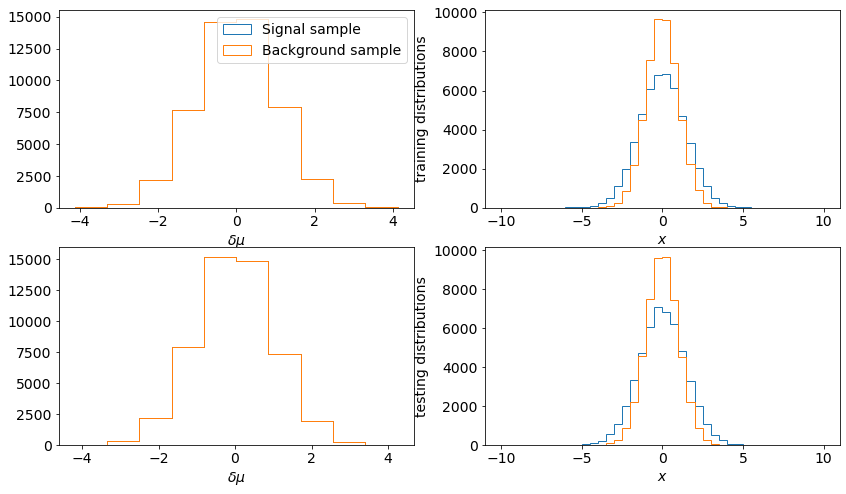

In [11]:
#print(x)
#print(f.flatten())
#plt.hist(x[f.flatten()==1,1],label="Signal sample")
#plt.hist(x[f.flatten()==0,1],label="Background sample")
#plt.legend()

# print(x[f.flatten()==1,1])
xn = x.numpy()
fn = f.numpy()

fig, axs = plt.subplots(2,2,figsize=(14, 8))
axs[0,0].hist(xn[fn.flatten()==1,1],label="Signal sample",histtype='step')
axs[0,0].hist(xn[fn.flatten()==0,1],label="Background sample",histtype='step')
axs[0,0].set_xlabel("$\delta\mu$")

axs[0,1].hist(xn[fn.flatten()==1,0],bins=numpy.arange(-10,10.5,0.5),label="Signal sample",histtype='step')
axs[0,1].hist(xn[fn.flatten()==0,0],bins=numpy.arange(-10,10.5,0.5),label="Background sample",histtype='step')

axs[0,1].set_xlabel("$x$")
axs[0,1].set_ylabel("training distributions")

xtn = xt.numpy()
ftn = ft.numpy()

axs[1,0].hist(xtn[fn.flatten()==1,1],label="Signal sample",histtype='step')
axs[1,0].hist(xtn[fn.flatten()==0,1],label="Background sample",histtype='step')
axs[1,0].set_xlabel("$\delta\mu$")

axs[1,1].hist(xtn[ftn.flatten()==1,0],bins=numpy.arange(-10,10.5,0.5),label="Signal sample",histtype='step')
axs[1,1].hist(xtn[ftn.flatten()==0,0],bins=numpy.arange(-10,10.5,0.5),label="Background sample",histtype='step')
axs[1,1].set_xlabel("$x$")
axs[1,1].set_ylabel("testing distributions")

axs[0,0].legend(loc='best')

In [12]:
# Now define the network and train it!

# Set this to a positive number to choose size of batches (or leave 0 for doing all events)
doBatchTraining=0

# The one below works fairly well-ish
"""
net2 = torch.nn.Sequential(
        torch.nn.Linear(2, 10),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(10, 20),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(20, 20),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(20, 10),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(10, 1),
        torch.nn.Sigmoid()
    )
"""
net2 = torch.nn.Sequential(
        torch.nn.Linear(2, 20),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(20, 20),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(20, 10),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(10, 1),
        #torch.nn.LeakyReLU(),
        #torch.nn.Sigmoid()
    )

net2.to(torch.double)
optimizer = torch.optim.AdamW(net2.parameters(), lr=0.1,weight_decay=0.0001)
loss_func = torch.nn.BCEWithLogitsLoss() 

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',min_lr=0.001)

MAXSTEPS=500
step = 0
losses = []
losses_t = []
LR = []
if not doBatchTraining>0 : 
    
    print("Training on all Events")

    #while MSE>0.1: #for t in range(n_epochs):

    with tqdm(range(MAXSTEPS)) as t:

        for i in t:
            prediction = net2(x)     # input x and predict based on x

            loss  = loss_func(prediction, f)     # must be (1. nn output, 2. target)
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
            losses.append((loss.detach().numpy().tolist()))
        
            scheduler.step(loss)
            # also plot loss for testing
            
            prediction_test = net2(xt)
            loss_t  = loss_func(prediction_test, ft) 
            losses_t.append((loss_t.detach().numpy().tolist()))
            LR.append(optimizer.param_groups[0]['lr'])
            t.set_postfix(loss_train=losses[-1],loss_test=losses_t[-1],lr=optimizer.param_groups[0]['lr'])      
        
    net2.eval()
    
else:
    print("Training on all batches size ",doBatchTraining)
    from torch.utils.data import DataLoader, TensorDataset

    dataset_train = TensorDataset( x, f )
    dataset_test = TensorDataset( xt, ft )

    train_dataloader = DataLoader(dataset_train, batch_size=doBatchTraining, shuffle=True)
    test_dataloader  = DataLoader(dataset_test, batch_size=doBatchTraining, shuffle=True)

    #while MSE>0.1: #for t in range(n_epochs):

    with tqdm(range(MAXSTEPS)) as t:

        for i in t:
            #print(next(iter(train_dataloader)))
            xb,fb =  next(iter(train_dataloader))
            xbt,fbt =  next(iter(test_dataloader))
            
            #xb[fb==0,1] = xb[fb==1,1]
            #xbt[fbt==0,1] = xbt[fbt==1,1]
            
            #print(xb,fb)
            prediction = net2(xb)     # input x and predict based on x

            loss  = loss_func(prediction, fb)     # must be (1. nn output, 2. target)
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
            
            #scheduler.step(loss)
            
            prediction_full      = net2(x)
            prediction_full_test = net2(xt)
            loss_test    = loss_func(prediction_full_test, ft) 
            loss_train   = loss_func(prediction_full, f) 
            LR.append(optimizer.param_groups[0]['lr'])
            
            losses_t.append(loss_test.detach().numpy().tolist())
            losses.append(loss_train.detach().numpy().tolist())
            t.set_postfix(loss_train = losses[-1],loss_test=losses_t[-1],lr=optimizer.param_groups[0]['lr'])      
        
    net2.eval()
    


Training on all Events


100%|████████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.19it/s, loss_test=0.649, loss_train=0.647, lr=0.001]


In [13]:
# create a network which is just a sigmoid function
little_net = torch.nn.Sequential(
    torch.nn.Sigmoid()
)

Text(0, 0.5, 'Learning rate')

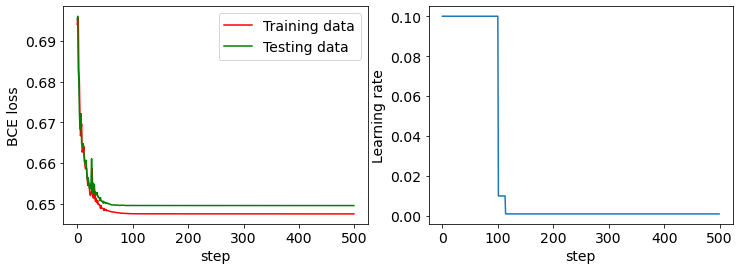

In [32]:
# Plot the losses and learning rate evolution 
fig, axs = plt.subplots(1,2,figsize=(12, 4))

axs[0].plot(range(len(losses)),losses, color='red' ,label="Training data")
axs[0].plot(range(len(losses_t)),losses_t, color='green',label="Testing data")
axs[0].set_xlabel("step")
axs[0].set_ylabel("BCE loss")
#axs[0].set_ylim(0.6,0.8)
axs[0].legend()

axs[1].plot(range(len(LR)), LR)
axs[1].set_xlabel("step")
axs[1].set_ylabel("Learning rate")


## Compare performance for fixed values of $\delta\mu$

With the model trained, we can check the performance vs the "best" possible (based on the LHR) with ROC plot. We're better off using the output of the NN directly since then it should be between 0 and 1. For the exact version, this means just evaluating $g(x)$.

In [15]:
# define functions to evaluate the NN and and exact value of p(S)/(p(S)+p(B)) each "event"
def g_NN_single(x,dm):
    # this should now be the qLR function 
    x = torch.reshape(torch.from_numpy(numpy.array([ [xx,dm] for xx in x])).type(torch.double),(len(x),2))
    f = little_net(net2(x))
    #z = f/(1-f)
    #z=f
    z = f.detach().numpy()
    return z.reshape(1,(len(z)))[0]
    #return -2*(numpy.log(z)).reshape(1,(len(z)))[0]

def g_True_single(xx,dm):
    n = 0.5*(norm.pdf(xx,mu_1_H1_p(dm),sigma_H0)+norm.pdf(xx,mu_2_H1_p(dm),sigma_H0))
    d = norm.pdf(xx,mu_H0,sigma_H0)    
    z = n/(n+d) 
    return z
    #return -2*(numpy.log(z))

Define a function to generate a simple array of values $x$ for any value of $\delta\mu$.

In [16]:
def mc_2G_3(n_events,dmu):
    mu_1_H1 = mu_H0+dmu
    mu_2_H1 = mu_H0-dmu
    
    xs = []
    for i in range(n_events):
        r = numpy.random.uniform(0,1)
        if  r > 0.5: xs.append(norm.rvs(mu_2_H1,sigma_H0,size=int(1))[0])
        else: xs.append(norm.rvs(mu_1_H1,sigma_H0,size=int(1))[0])
    
    return numpy.array(xs)

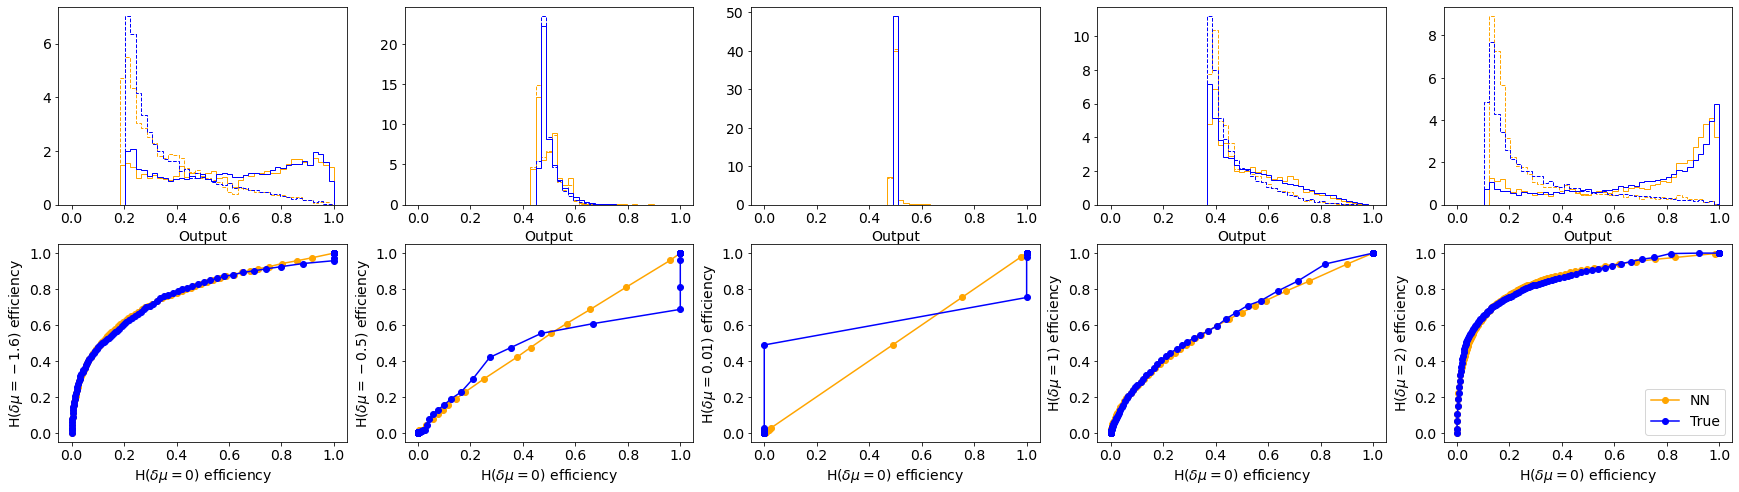

In [17]:
delta_mu_test_values = [-1.6,-0.5,0.01,1.0,2.0]

fig, ax = plt.subplots(2,len(delta_mu_test_values),figsize=(6*len(delta_mu_test_values), 8))

n_gen_test = 10000
# generate a "background" dataset 
background_sample = mc_2G_3(n_gen_test,0)

for i,delta_mu_true in enumerate(delta_mu_test_values): 
    g_lr_background_NN   = g_NN_single(background_sample,delta_mu_true)
    g_lr_background_Tr   = g_True_single(background_sample,delta_mu_true)

    # generate a dataset for this signal point
    signal_sample = mc_2G_3(n_gen_test,delta_mu_true)
    
    # feed each through the network 
    g_lr_signal_NN   = g_NN_single(signal_sample,delta_mu_true)
    g_lr_signal_Tr   = g_True_single(signal_sample,delta_mu_true)
    
    cuts_range = numpy.linspace(0,1,100)
    
    s_eff_NN   = [float(len(list(filter(lambda x : x > cr, g_lr_signal_NN ))))/n_gen_test for cr in cuts_range]
    b_eff_NN   = [float(len(list(filter(lambda x : x > cr, g_lr_background_NN ))))/n_gen_test for cr in cuts_range]
    
    s_eff_Tr   = [float(len(list(filter(lambda x : x > cr, g_lr_signal_Tr ))))/n_gen_test for cr in cuts_range]
    b_eff_Tr   = [float(len(list(filter(lambda x : x > cr, g_lr_background_Tr ))))/n_gen_test for cr in cuts_range]
   
    bins = numpy.linspace(0,1,50)
    
    ax[0,i].hist(g_lr_signal_NN,bins=bins,color='orange',histtype='step',density=True)
    ax[0,i].hist(g_lr_background_NN,bins=bins,color='orange',histtype='step',linestyle='dashed',density=True)
    ax[0,i].hist(g_lr_signal_Tr,bins=bins,color='blue',histtype='step',density=True)
    ax[0,i].hist(g_lr_background_Tr,bins=bins,color='blue',histtype='step',linestyle='dashed',density=True)
    ax[0,i].set_xlabel("Output")
    
    #print(delta_mu_true,s_eff_NN)
    ax[1,i].plot(b_eff_NN,s_eff_NN,color='orange',label="NN",marker='o')
    ax[1,i].plot(b_eff_Tr,s_eff_NN,color='blue',label="True",marker='o')
    ax[1,i].set_xlabel("H($\delta\mu=0$) efficiency")
    ax[1,i].set_ylabel("H($\delta\mu=%g$) efficiency"%(delta_mu_true))

plt.legend()

In [30]:
# Check the function in 2D

def q_function_single(x):
    return -2*(numpy.log(x))

xr_plotting = numpy.linspace(-5, 5, 50) # x
dm_plotting = numpy.linspace(-3, 3, 10) # delta_mu

#for dm in dm_plotting: 
def plot_compare_q(dm):
    z   = q_function_single(g_NN_single(xr_plotting,dm))
    zT  = q_function_single(g_True_single(xr_plotting,dm))
    plt.plot(xr_plotting,z,color='orange')
    plt.xlabel("$x$")
    plt.ylabel("$g(x,\delta\mu=%.2f)$"%dm)
    plt.plot(xr_plotting,zT,color='blue')
    #plt.yscale("log")
    #plt.annotate("%.1f"%dm,(numpy.log(xr_plotting[-1]),numpy.log(z[-1])))
    
ipywidgets.interact(plot_compare_q,dm=(-3,3,0.1))

interactive(children=(FloatSlider(value=0.0, description='dm', max=3.0, min=-3.0), Output()), _dom_classes=('w…

<function __main__.plot_compare_q(dm)>

## Checking the likelihood for an "observed" dataset

Now we have our trained neural network, lets generate some data and see if we can fit the value of $\delta\mu$. First we write something to ssum over the individual values - i.e the $q$ for our dataset.

In [19]:
def qLR(x,dm):
    # this should now be the qLR function 
    x = torch.reshape(torch.from_numpy(numpy.array([ [xx,dm] for xx in x])).type(torch.double),(len(x),2))
    f = little_net(net2(x))
    z = f/(1-f)
    z = z.detach().numpy()
    return (-2*sum(numpy.log(z)))[0]

print(qLR([5,3,2],0.3))

-7.54718418904289


Now we are going to generate some data from the model where $\delta\mu=1.6$ (this is our *true* parameter value). We can generate 100 random values of $x$ from this model. 

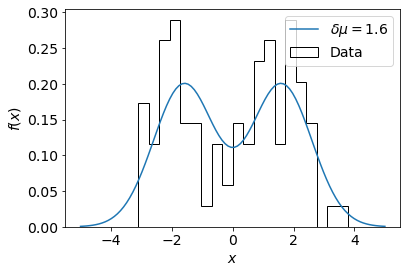

In [20]:
# now invent some data 
true_delta_mu = 1.6

data = mc_2G_3(100,true_delta_mu)
plt.hist(data,20,density=True,label="Data",histtype='step',color='black')

plt.plot(xr,0.5*(norm.pdf(xr,mu_1_H1_p(true_delta_mu),sigma_H0)+norm.pdf(xr,mu_2_H1_p(true_delta_mu),sigma_H0)),label="$\delta\mu=%g$"%true_delta_mu)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()

Since we have the exact form of the pdf ($f(x)$) in this case, we can define the usual log-likelihood to compare to our neural net approach! 

$$
q_{exact} = -2 \sum_{i}\ln f(x_{i};\delta\mu)
$$

This is our exact log-likelihood. We explicitly subtract the exact value of $q(\delta\mu=0)$ to make a comparison with our neural network that has that value in the denominator.

In [21]:
# now we can do the usual ratio, lets plot it 
def normalqLR(xx,dm):
    #z = []
    #for x in xx: 
    n = 0.5*(norm.pdf(xx,mu_1_H1_p(dm),sigma_H0)+norm.pdf(xx,mu_2_H1_p(dm),sigma_H0))
    d = norm.pdf(xx,mu_H0,sigma_H0)    
    z = (n/d) 
    return -2*sum(numpy.log(z))

In [22]:
print(normalqLR(data,0.4))

-32.86550443184923


Now compare the two likelihood functions - you can see the NN is doing an ok-ish job. The minimum is certainly near the true value.

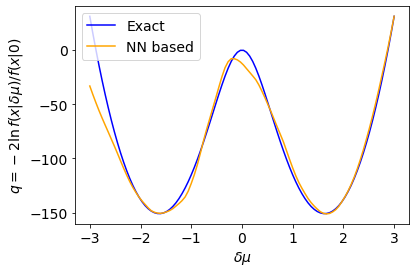

In [23]:
dmrange = numpy.linspace(-3,3,100)

res_normal_q  = [normalqLR(data,dm) for dm in dmrange]
res_nn_q      = [qLR(data,dm) for dm in dmrange]
plt.plot(dmrange,res_normal_q,label="Exact",color='blue')
plt.plot(dmrange,res_nn_q,label="NN based",color='orange')
plt.xlabel("$\delta\mu$")
plt.ylabel("$q = -2\ln f(x|\delta\mu)/f(x|0)$")
plt.legend()

Ok, next we will check if the gradient for our neural network is smooth (we could actually plug this into a minimizer such as `iminuit` or `scipy.optimize` which accepts the gradient as a function, but we won't bother here) 

In [24]:
def q(x, dm): 
    x[:,1] = dm
    f = little_net(net2(x))
    z = f/(1-f)
    q = -2*torch.sum(torch.log(z))
    return q

tensor(-126.5717, dtype=torch.float64)


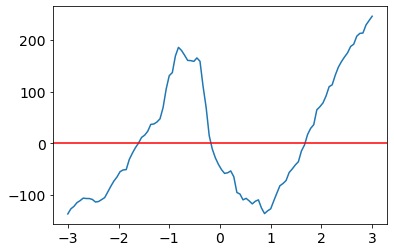

In [25]:
def grad(data,dm):
    dm_tensor = torch.tensor(dm, dtype=torch.float64, requires_grad=True)
    #print(data)
    
    data_concat = numpy.concatenate([[data], [numpy.zeros_like(data)]], axis=0).T
    data_tensor = torch.tensor(data_concat, dtype=torch.float64)
    #print(data_tensor.shape)
    
    qx = q(data_tensor, dm_tensor)
    #print(qx)
    qx.backward(retain_graph=True)
    dq = dm_tensor.grad
    #print(dq)
    return dq

print(grad(data, 1))
plt.plot(dmrange,[grad(data,dm) for dm in dmrange],label="NN based gradient?")
plt.axhline(0,color='red')

Looks nice, and indeed the gradient is 0 near the minimum!

## Now Let's see what happens if we try to bin the output of the NN

It is tempting to try to use the NN output from our data and bin it to construct a typical histogram based fit. In this case, we would need to also produce the expected histogram from our simulation. For each value of $\delta\mu$, our histogram would be different since the network responds differently, for both the data and expectation.  

In the example below, I use the same dataset as above but this time, I pass it through the NN (for a particular value of $\delta\mu$ and bin the output into 11 bins of equal width in a reasonable range. In order to populate the expected histogram, I generate simulation from the model ($f(x;\delta\mu)$) and pass it through the network with that value of $\delta\mu$ (the same as is being used when passing the data) and bin the output in the same histogram bins.  

Rather than just taking the output of the NN directly, I pass it through a function that *should* cap the value at 0, $$
x\rightarrow -2\ln\left(\frac{\hat{g}(x)}{1-\hat{g}(x)}\right)
$$

In [26]:
# first bin the data into some output
bins = numpy.linspace(0,1,20)

def plot_dist(dm):
    distribution_from_mc = mc_2G_3(1000,dm)
    #fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
    plt.hist(g_NN_single(data,dm),bins=bins,histtype='step',color='black',density=True,label="data $\delta\mu=%.2f$"%dm)
    plt.hist(g_NN_single(distribution_from_mc,dm),bins=bins,histtype='step',color='red',density=True,label="expected $\delta\mu=%.2f$"%dm)
    
    #plt.ylim(0,5.0)
    plt.xlabel("NN output")
    plt.legend()
    
ipywidgets.interact(plot_dist,dm=(0,3,0.1))


interactive(children=(FloatSlider(value=1.0, description='dm', max=3.0), Output()), _dom_classes=('widget-inte…

<function __main__.plot_dist(dm)>

Now I assume everything else procedes as normal and construct the usual Poisson likelihood to form my test statistic.

In [27]:
def poisson_lh(data,sim):
    # normalise the simulation to data 
    sum_sim  = sum([s for s in sim])
    sum_data = sum([d for d in data])
    l = 0 
    for d,s in zip(data,sim):
        if s==0: s=0.001 # can we even do this?
        s = s*sum_data/sum_sim 
        l += d*numpy.log(s)-s
    return -2*l

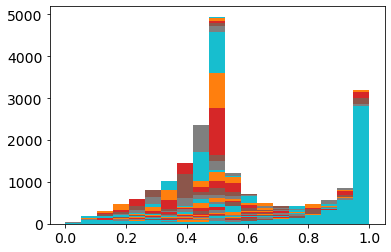

In [28]:
res_binned_q = []
for dm in dmrange: 
    distribution_from_mc = mc_2G_3(5000,dm)
    hist_data = plt.hist(g_NN_single(data,dm),bins=bins)[0]
    hist_mc   = plt.hist(g_NN_single(distribution_from_mc,dm),bins=bins)[0]
    #print(hist_mc)
    res_binned_q.append(poisson_lh(hist_data,hist_mc))

Finally, let's compare all three lines for $q(\delta\mu)$. This time, I subtract the minimum point in each curve to better compare since the Poisson likelihood will not have the same arbitrary offset as the others. 

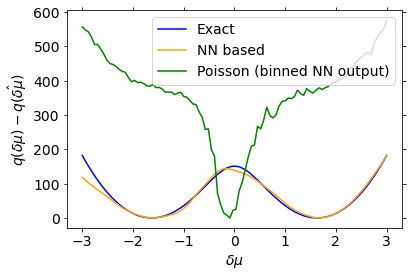

In [29]:
plt.cla()
plt.plot(dmrange,res_normal_q-min(res_normal_q),label="Exact",color='blue')
plt.plot(dmrange,res_nn_q-min(res_nn_q),label="NN based",color='orange')
plt.plot(dmrange,res_binned_q-min(res_binned_q),color='green',label='Poisson (binned NN output)')
plt.xlabel("$\delta\mu$")
plt.ylabel("$q(\delta\mu)-q(\hat{\delta\mu})$")
plt.legend()